In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager

import corner

import binary_c
import xrb
import xrb.src.constants as c
from xrb.binary import binary_evolve
from xrb.src import stats


from xrb.src.core import *
set_data_path("../data")

from xrb.models import HMXB



%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [ ]:
start = time.time()

sampler = HMXB.run_emcee_population(nburn=20000, nsteps=50000, nwalkers=80)

end = time.time()

print "Elapsed time:", int((end-start)/3600), "hours and", (end-start)%3600.0, "seconds"

Setting walkers...
...walkers are set

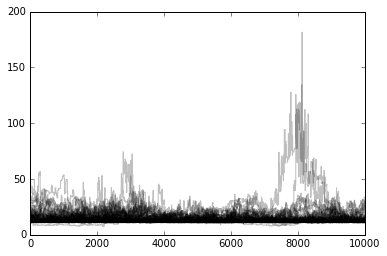

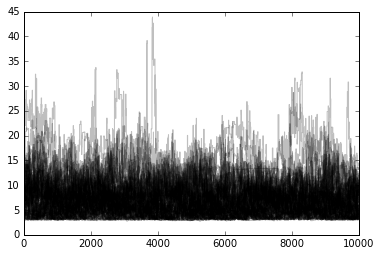

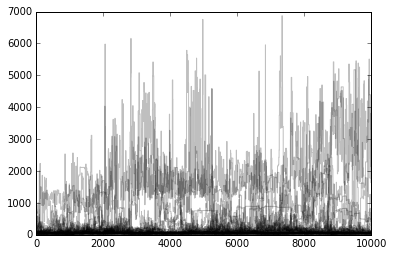

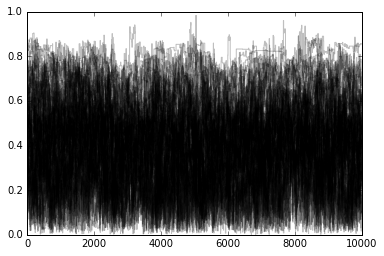

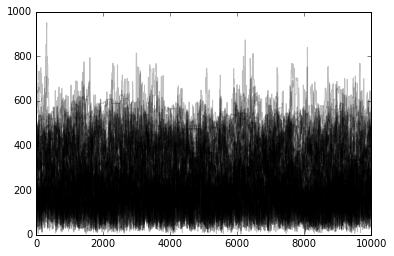

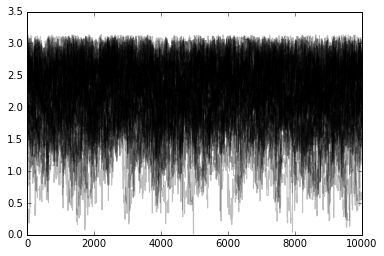

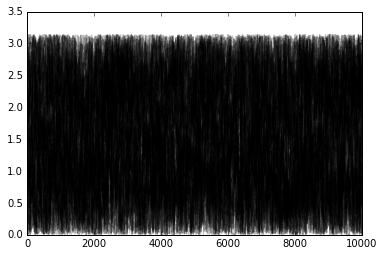

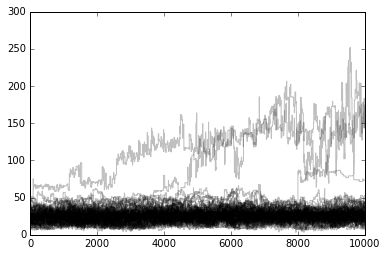

In [3]:
for i in range(sampler.dim):
    plt.figure()
    for chain in sampler.chain[...,i]:
        if i < 3:
            plt.plot(10**chain, alpha=0.25, color='k', drawstyle='steps')
        else:
            plt.plot(chain, alpha=0.25, color='k', drawstyle='steps')
        
plt.show()

In [4]:
import pickle

pickle.dump(sampler, open("../data/HMXB_population.obj", "wb"))

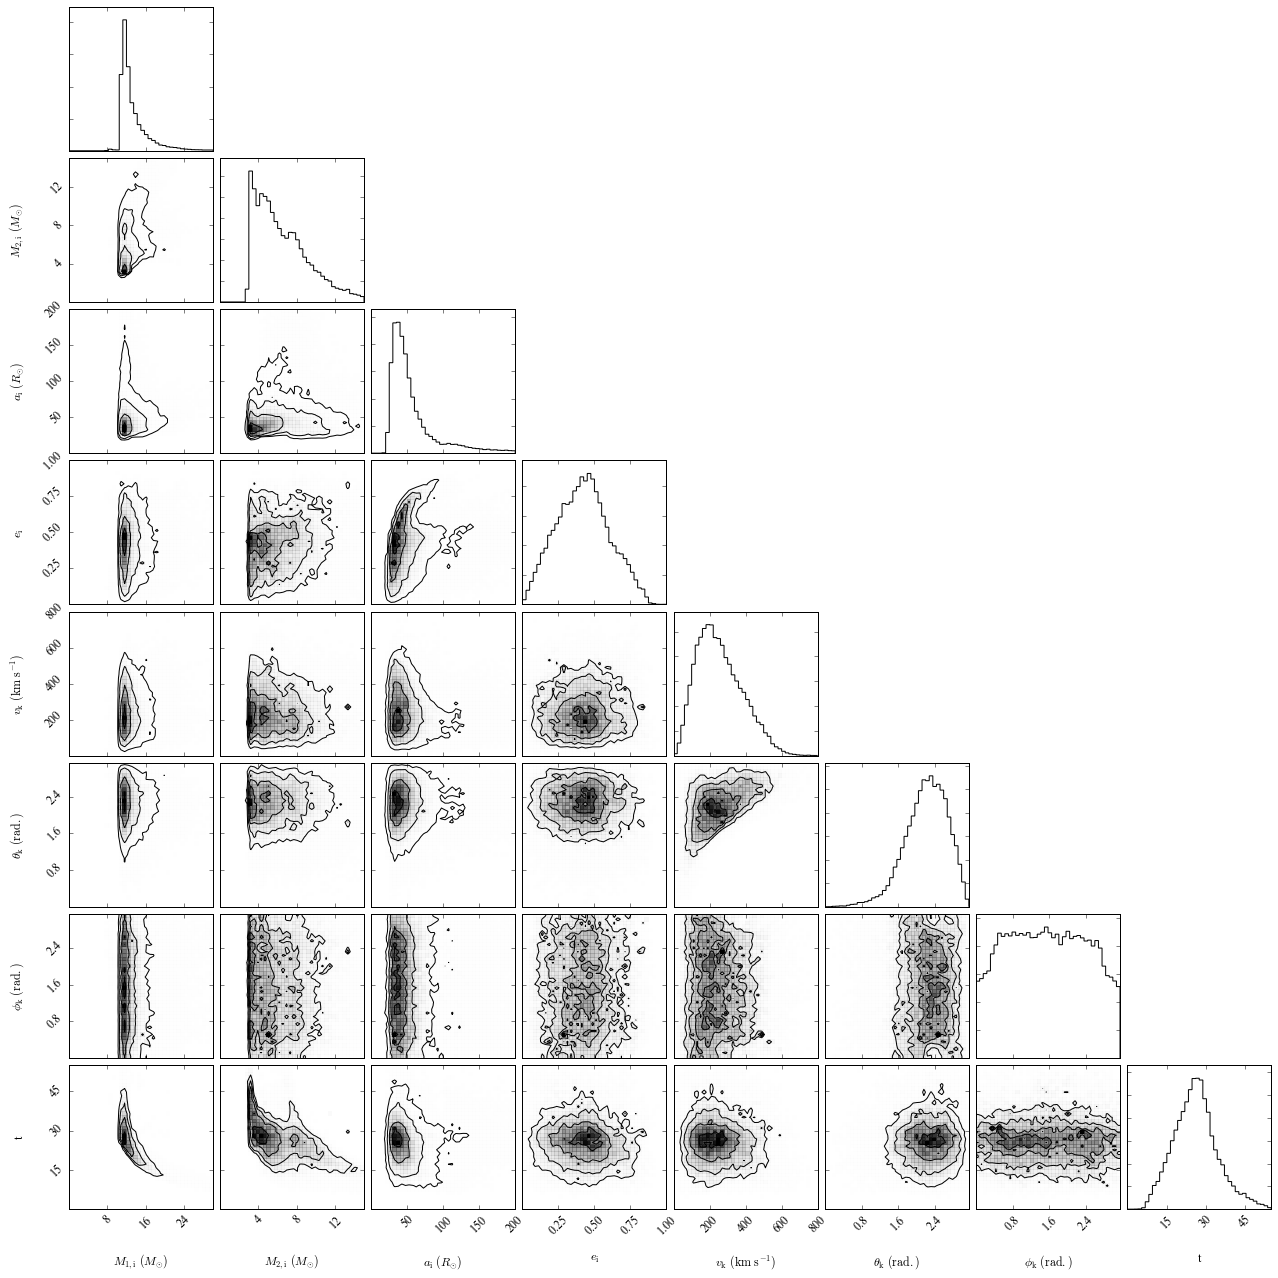

In [27]:
from matplotlib import font_manager
import corner

# Corner plot
fontProperties = {'family':'serif', 'serif':['Times New Roman'], 'weight':'normal', 'size':12}
ticks_font = font_manager.FontProperties(family='Times New Roman', style='normal', \
                                         weight='normal', stretch='normal', size=12)
plt.rc('font', **fontProperties)

# fig, ax = plt.subplots(10,10, figsize=(10,10))

chain = sampler.flatchain
sampler_data = np.array([10**chain.T[0], 10**chain.T[1], 10**chain.T[2], chain.T[3], \
                         chain.T[4], chain.T[5], chain.T[6], chain.T[7]]).T


labels = [r"$M_{\rm 1, i}\ (M_{\odot})$", r"$M_{\rm 2, i}\ (M_{\odot})$", r"$a_{\rm i}\ (R_{\odot})$", \
          r"$e_{\rm i}$", r"$v_{\rm k}\ ({\rm km}\ {\rm s}^{-1})$", \
          r"$\theta_{\rm k}\ ({\rm rad.})$", r"$\phi_{\rm k}\ ({\rm rad.})$", r"t"]
plt_range = ([0,30], [0,15], [0,200], [0,1], [0,800], [0,np.pi], [0,np.pi], [0, 55.0])


hist2d_kwargs = {"plot_datapoints" : False}
fig = corner.corner(sampler_data, labels=labels, range=plt_range, max_n_ticks=4, bins=40, **hist2d_kwargs)


plt.savefig('../population_HMXB_test_1.pdf', rasterized=True)
# plt.show()